### Entranamiento / Evaluación

In [202]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


#### 💪 Training

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [204]:
proc_data_path='../data/processed/road_traffic_accidents_dataset_proc.csv'
train_data = pd.read_csv(proc_data_path)


In [205]:
x = train_data.drop('accident_severity', axis=1)
y = train_data['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


In [206]:
print('Train x shape:', xtrain.shape)
print('Train y shape:', ytrain.shape)
print('Test x shape:', xtest.shape)
print('Test y shape:', ytest.shape)

xtrain.to_csv('../data/train/xtrain.csv', index=False)
ytrain.to_csv('../data/train/ytrain.csv', index=False)
xtest.to_csv('../data/test/xtest.csv', index=False)
ytest.to_csv('../data/test/ytest.csv', index=False)


Train x shape: (2311, 236)
Train y shape: (2311,)
Test x shape: (578, 236)
Test y shape: (578,)


In [207]:
models={"LogisticRegression":LogisticRegression(max_iter=1000),
        "DecisionTreeClassifier":DecisionTreeClassifier(random_state=42),
        "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=5),
        # "SVC":SVC(kernel="linear", C=0.0001),
        "RandomForestClassifier":RandomForestClassifier(n_estimators=200, random_state=42),
        # "AdaBoostClassifier":AdaBoostClassifier(n_estimators=200, random_state=42),
        # "GradientBoostingClassifier":GradientBoostingClassifier(n_estimators=200, random_state=42),
        }


In [208]:
# models,x,y,scaleFlag=0,1,2
def modelAccuracy(models,x,y,scaleFlag):
    #train/Test
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
    acc_result={}
    for name,model in models.items():
        #pipeline
        #1.Transformer -> 2.Model
        if(scaleFlag==1):
            model_pipeline=Pipeline([('MinMaxScler',MinMaxScaler()),('model',model)])
        elif(scaleFlag==2):
             model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])
        else:
            model_pipeline=Pipeline([('model',model)])
        #training/testing on model pipeline
        model_fit=model_pipeline.fit(xtrain,ytrain)
        ypred=model_fit.predict(xtest)
        acc=accuracy_score(ytest,ypred)
        print("The Accuracy for {:<25} is: {:>16.13f}".format(name, acc))
        acc_result[name]=acc
    return acc_result

In [209]:
# def bestModel(result):
#     high=0
#     for name,acc in result.items():
#         if acc>high:
#             high=acc
#             model_name=name
#     print("Best Model is ",model_name," with accuaracy =>",high)

In [210]:
# def bestParams(model,param,xtrain,ytrain):
#     #cv
#     cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
#     grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="f1_weighted")
#     res=grid_cv.fit(xtrain,ytrain)
#     print("Best Parameters are ",res.best_params_)
#     print("Best Accuracy is ",res.best_score_)

In [211]:
acc_result=modelAccuracy(models,x,y,0)

The Accuracy for LogisticRegression        is:  0.8529411764706
The Accuracy for DecisionTreeClassifier    is:  0.7647058823529
The Accuracy for KNeighborsClassifier      is:  0.8667820069204
The Accuracy for RandomForestClassifier    is:  0.8702422145329


In [212]:
acc_result=modelAccuracy(models,x,y,1)

The Accuracy for LogisticRegression        is:  0.8529411764706
The Accuracy for DecisionTreeClassifier    is:  0.7647058823529
The Accuracy for KNeighborsClassifier      is:  0.8650519031142
The Accuracy for RandomForestClassifier    is:  0.8702422145329


In [213]:
acc_result=modelAccuracy(models,x,y,2)

The Accuracy for LogisticRegression        is:  0.8408304498270
The Accuracy for DecisionTreeClassifier    is:  0.7647058823529
The Accuracy for KNeighborsClassifier      is:  0.8598615916955
The Accuracy for RandomForestClassifier    is:  0.8702422145329


In [214]:
def bestModel(result):
    high=0
    for name,acc in result.items():
        if acc>high:
            high=acc
            model_name=name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [215]:
bestModel(acc_result)

Best Model is  RandomForestClassifier  with accuaracy => 0.870242214532872


In [216]:
def bestParams(model,param,xtrain,ytrain):
    #cv
    cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="f1_weighted")
    res=grid_cv.fit(xtrain,ytrain)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)


In [217]:
model=RandomForestClassifier()
params={"n_estimators" : [50,100,200],
        # "max_depth" : [10,20,30,40,50],
        # "min_samples_split" : [2,5,10],
        # "min_samples_leaf" : [1,2,4],
        "max_leaf_nodes" : [5,10,20,30],
        # "criterion" : ["gini","entropy"]
        }
bestParams(model,params,xtrain,ytrain)

Best Parameters are  {'max_leaf_nodes': 5, 'n_estimators': 50}
Best Accuracy is  0.7802549245075218


In [221]:
#retrain the model with best parameters
model=RandomForestClassifier(n_estimators=50, max_leaf_nodes=5, class_weight='balanced')
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)


In [222]:
#export the model
import pickle
pickle.dump(model,open("../models/road_traffic_accidents_model.pkl","wb"))


Accuracy: 0.6020761245674741

Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.25      0.09         8
           1       0.16      0.46      0.24        67
           2       0.90      0.63      0.74       503

    accuracy                           0.60       578
   macro avg       0.37      0.45      0.36       578
weighted avg       0.81      0.60      0.67       578


Confusion Matrix:
[[  2   4   2]
 [  4  31  32]
 [ 33 155 315]]


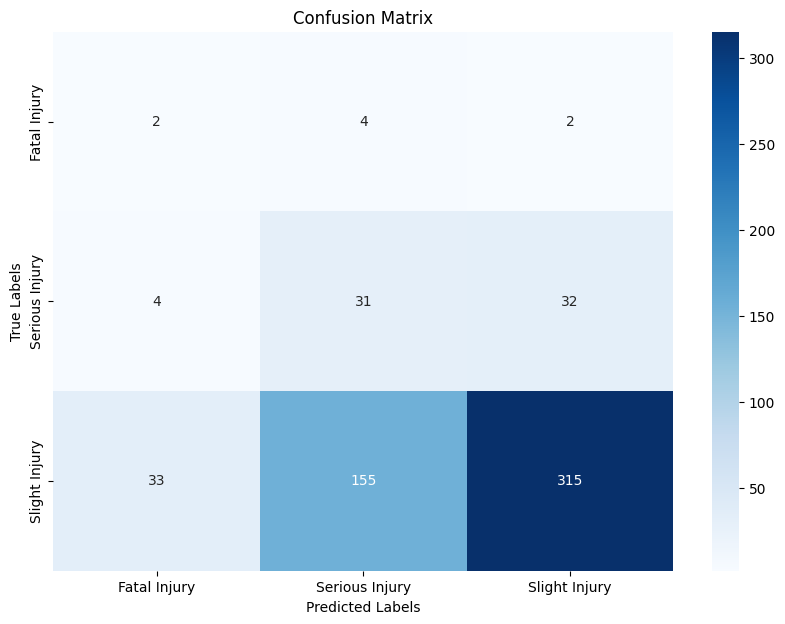

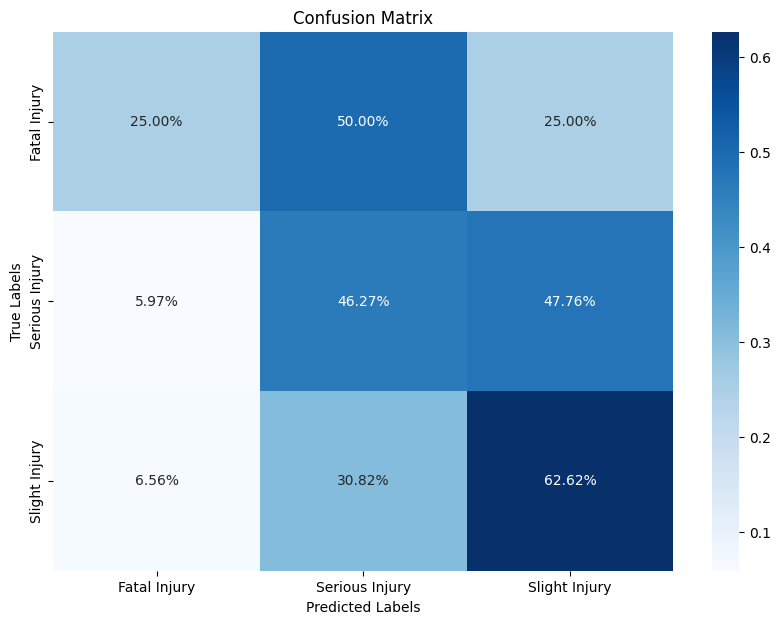

In [223]:
#Final Evaluation

# Print accuracy
print("Accuracy:", accuracy_score(ytest, ypred))

# Print classification report with zero_division parameter
print("\nClassification Report:")
print(classification_report(ytest, ypred, zero_division=0))  # Set zero_division to 0

# Generate and plot confusion matrix
c_matrix = confusion_matrix(ytest, ypred)
print("\nConfusion Matrix:")
print(c_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(ytest, ypred, normalize='true'), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Feature Importances:
                                  feature  importance
162                number_of_casualties_4    0.073861
46       vehicle_driver_relation_employee    0.050645
115         types_of_junction_no junction    0.042336
39    educational_level_above high school    0.029264
114            types_of_junction_crossing    0.028997
185                  sex_of_casualty_male    0.028310
27                     day_of_week_sunday    0.026489
136             weather_conditions_normal    0.025947
4                                  time_4    0.024641
87   area_accident_occured_  market areas    0.021646


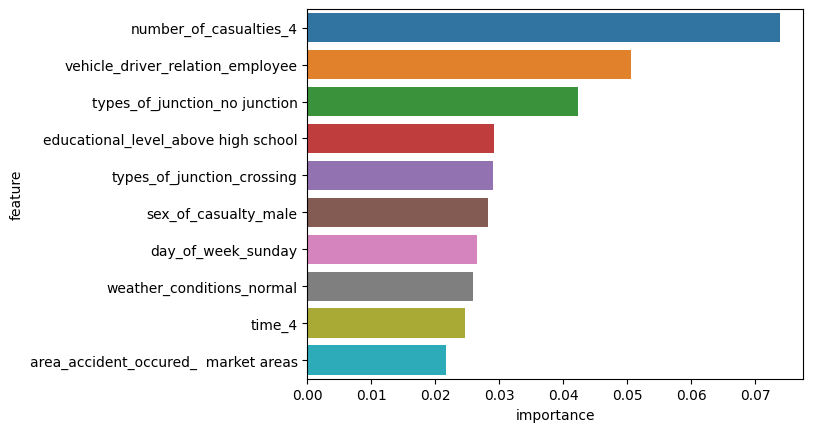

In [233]:
# Print the feature importances
feature_importances = model.feature_importances_
feature_names = x.columns
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances_df.head(10))

sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), hue='feature');


#### 🎯 Predict